In [1]:
from sympy import *
init_printing(order='none')
# Givens
r_w = symbols("r_w", real=True, finite=True, positive=True)
r_p = symbols("r_p", real=True, finite=True, positive=True)
I_p = symbols("I_p", real=True, finite=True, positive=True)
I_w = symbols("I_w", real=True, finite=True, positive=True)
m_p = symbols("m_p", real=True, finite=True, positive=True)
v_p = symbols("v_p", real=True, finite=True, positive=True)
v_pi = symbols("v_{pi}", real=True, finite=True, nonnegative=True)
omega_pi = symbols("\\omega_{pi}", real=True, finite=True, nonnegative=True)
v_pf = symbols("v_{pf}", real=True, finite=True, positive=True)
omega_pf = symbols("\\omega_{pf}", real=True, finite=True, positive=True)

# Unknowns
omega_wi = symbols("\\omega_{wi}", real=True, finite=True, positive=True)
omega_wf = symbols("\\omega_{wf}", real=True, finite=True, positive=True)
omega_p = symbols("\\omega_p", real=True, finite=True, positive=True)
J_w = symbols("J_w", real=True, finite=True, positive=True)
J_h = symbols("J_h", real=True, finite=True, positive=True)

from IPython.display import Markdown

def display_eq(expr, label="", uneval_exprs=[]):
    wild = Wild("wild")
    wild2 = Wild("wild2")
    for e in uneval_exprs:
        expr = expr.subs(e, UnevaluatedExpr(e))
        expr = expr.replace(UnevaluatedExpr(wild)**wild2, UnevaluatedExpr(UnevaluatedExpr(wild)**wild2))
        expr = expr.replace(wild*UnevaluatedExpr(wild2), UnevaluatedExpr(wild)*UnevaluatedExpr(wild2))
    return display(Markdown(f'<div style="text-align: center">\n\n#### {label}\n\n</div>\n\n' + '\\begin{equation}\n' + f'{latex(expr)}' + ' \\end{equation}'))

# Flywheel Shooter Analysis

Dean Brettle  
Mentor  
Carlmont Robotics, FRC Team 199, Deep Blue  
dean.brettle@carlmontrobotics.org

## Abstract

This paper describes a new mathematical model for the physics of a hooded flywheel shooter, derives equations for the initial wheel velocity and the ratio of the initial wheel velocity to the final wheel velocity, and compares the results to previous work. The analysis predicts that the wheel speed lost during a shot is half of what is predicted by previous work. A formula for the shooter's mechanical efficiency is also derived and shown to be less than 50%.

## Preface

This is a [Jupyter notebook](https://jupyter.org/) or the output of one. The source code is currently [available on GitHub](https://github.com/DeepBlueRobotics/jupyter_notebooks/blob/master/FlywheelShooter.ipynb). There is also [a web page which omits the source code](https://deepbluerobotics.github.io/jupyter_notebooks/files/FlywheelShooter.html) and [an interactive *read-only* version of the notebook](https://deepbluerobotics.github.io/jupyter_notebooks/lab?path=FlywheelShooter.ipynb). For further information, including instructions for contributing, see the [README.md](https://github.com/DeepBlueRobotics/jupyter_notebooks/).


To avoid unnecessary conversion factors, all quantities are assumed to be in [SI units](https://en.wikipedia.org/wiki/International_System_of_Units). In particular, note that rotational velocities are in **radians per second (rad/sec), _not_ revolutions per minute (RPM)**.

## Introduction

Consider the following figures showing a projectile of radius $r_p$, mass $m_p$, and moment of inertia $I_p$ as it passes through a shooter where the wheel has radius $r_w$, mass $m_w$, and moment of inertia $I_w$.

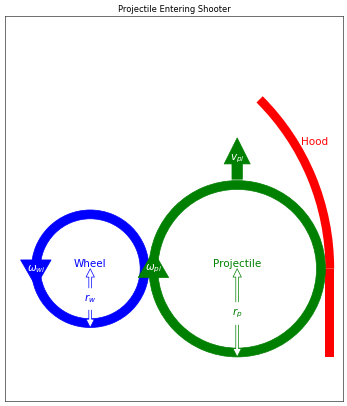

In [2]:
from matplotlib.patches import Circle, Wedge, Polygon, RegularPolygon, Rectangle, FancyArrowPatch
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import numpy
import math

def add_labeled_circle(ax, x, y, radius, width, color, arrow_width, label, radius_label, speed_label, label_size, direction="cw"):
    ax.add_patch(Wedge((x, y), radius, 0, 360, width=width, color=color))
    ax.text(x, y, label, ha="center", va="bottom", color=color, backgroundcolor="w", size=label_size)
    if (speed_label != None):
        ax.add_patch(RegularPolygon((x-radius+width/2, y), 3, radius=2*width, orientation=(math.pi if direction == "cw" else 0), color=color))
        ax.text(x-radius+width/2, y, speed_label, ha="center", va="center", color="w", size=label_size)

    # Radius arrows and label
    ax.annotate("",
                xy=(x, y), xycoords='data',
                xytext=(x, y-radius/2), textcoords='data',
                size=label_size, va="center", ha="center", color=color,
                arrowprops=dict(color=color,
                                fc="w",
                                width=arrow_width),
    )
    ax.annotate("",
                xy=(x, y-radius), xycoords='data',
                xytext=(x, y-radius/2), textcoords='data',
                size=label_size, va="center", ha="center", color=color,
                arrowprops=dict(color=color,
                                fc="w",
                                width=arrow_width),
    )
    ax.text(x, y-radius/2, radius_label, ha="center", va="center", color=color, backgroundcolor="w", size=label_size)



def display_shooter(title, omega_w_label, omega_p_label, v_p_label, show_impulses=False, theta=math.pi/8):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=50)

    r_w = 0.2
    r_p = 0.3
    r_h = r_w+2*r_p

    p_center = ((r_w+r_p)*math.cos(theta), (r_w+r_p)*math.sin(theta))
    # if theta < 0:
    #     p_center = (r_w+r_p, -r_p/3)
    # elif theta > math.pi/4:
    #     p_center = ((r_w+r_p)*math.cos(math.pi/4)-r_p/3, (r_w+r_p)*math.sin(math.pi/4)+r_p/3)

    width = 0.03

    w_color = "blue"
    p_color = "green"
    h_color = "red"

    label_size = 15
    arrow_length = 0.35
    arrow_width = 4

    bounds = [-r_w-3*width, r_w+2*r_p+2*width, -r_p-5*width, r_w+2*r_p+2*width]

    # Hood
    ax.text((r_h+width)*math.cos(math.pi/6), (r_h+width)*math.sin(math.pi/6), r'Hood', ha="left", va="bottom", color=h_color, size=label_size)
    ax.add_patch(Wedge((0, 0), r_h, 0, 45, width=-width, color=h_color, linewidth=0))
    ax.add_patch(Rectangle((r_h, 0), width, -r_p, color=h_color, linewidth=0))
    
    # Wheel
    add_labeled_circle(ax, 0, 0, r_w, width, w_color, arrow_width, "Wheel", "$r_w$", omega_w_label, label_size, direction="cw")
    
    # Projectile
    add_labeled_circle(ax, p_center[0], p_center[1], r_p, width, p_color, arrow_width, "Projectile", "$r_p$", omega_p_label, label_size, direction="ccw")

    if v_p_label != None:
        # Projectile velocity
        t = Affine2D().rotate(theta+math.pi/2).translate(p_center[0], p_center[1])
        ax.add_patch(FancyArrowPatch(t.transform((r_p, 0)), t.transform((r_p+0.15, 0)),
                                        color=p_color,
                                        mutation_scale=75
                                        ))
        v_p_label_pos = t.transform((r_p+0.075, 0))
        ax.text(v_p_label_pos[0], v_p_label_pos[1], v_p_label, ha="center", va="center", color="w", size=label_size)
    if show_impulses:
        # Wheel->Projectile impulse
        w_p_contact = ((r_w)*math.cos(theta), (r_w)*math.sin(theta))
        ax.annotate("$J_w$",
                    xy=w_p_contact, xycoords='data',
                    xytext=(w_p_contact[0]+arrow_length*math.cos(theta-math.pi/2), w_p_contact[1]+arrow_length*math.sin(theta-math.pi/2)), textcoords='data',
                    size=label_size, va="center", ha="center", color=p_color,
                    arrowprops=dict(color=p_color,
                                    fc="w",
                                    width=arrow_width),
        )


        # Hood->Projectile impulse
        h_p_contact = ((r_w+2*r_p)*math.cos(theta), (r_w+2*r_p)*math.sin(theta))
        ax.annotate("$J_h$",
                    xy=h_p_contact, xycoords='data',
                    xytext=(h_p_contact[0]+arrow_length*math.cos(theta+math.pi/2), h_p_contact[1]+arrow_length*math.sin(theta+math.pi/2)), textcoords='data',
                    size=label_size, va="center", ha="center", color=p_color,
                    arrowprops=dict(color=p_color,
                                    fc="w",
                                    width=arrow_width),
        )

        # Projectile->Wheel impulse
        ax.annotate("$J_w$",
                    xy=w_p_contact, xycoords='data',
                    xytext=(w_p_contact[0]+arrow_length*math.cos(theta+math.pi/2), w_p_contact[1]+arrow_length*math.sin(theta+math.pi/2)), textcoords='data',
                    size=label_size, va="center", ha="center", color=w_color,
                    arrowprops=dict(color=w_color,
                                    fc="w",
                                    width=arrow_width),
        )

    
    ax.set_title(title)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.axis(bounds)

    plt.show()

display_shooter('Projectile Entering Shooter', r'$\omega_{wi}$', r'$\omega_{pi}$', r'$v_{pi}$',  theta=0)


When the projectile enters the shooter, the shooter wheel has an initial velocity of $\omega_{wi}$ and the projectile has an initial rotational velocity of $\omega_{pi}$ and an initial linear velocity of $v_{pi}$.

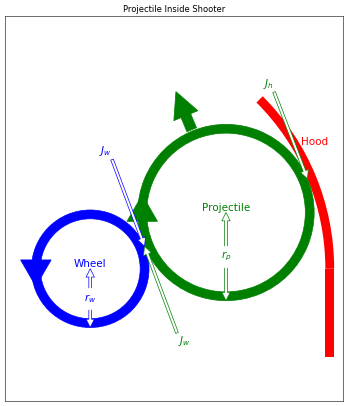

In [3]:
display_shooter('Projectile Inside Shooter', r'', r'', r'', show_impulses=True, theta=math.pi/8)

While the projectile is in the shooter:

1. The contact between the surface of the shooter wheel and the surface of the projectile produces an impulse on each of them (in opposite directions) of magnitude $J_w$.
2. The contact between the hood and the surface of the projectile produces an additional impulse on the projectile, on the opposite side and in the opposite direction, of magnitude $J_h$.
3. The net effect of the two impulses on the projectile is to increase its linear and rotational velocity.
4. The effect of the impulse on the shooter wheel is to decrease its rotational velocity.

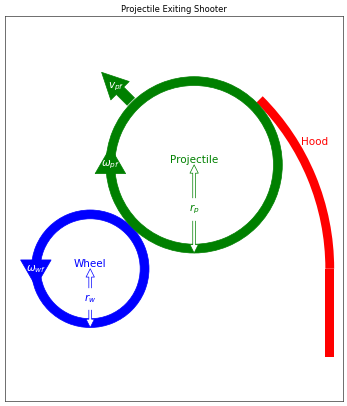

In [4]:
display_shooter('Projectile Exiting Shooter', r'$\omega_{wf}$', r'$\omega_{pf}$', r'$v_{pf}$', theta=math.pi/4)

When the projectile exits the shooter it has a final linear velocity $v_p$ and rotational velocity $\omega_p$ and the shooter wheel has a final rotation velocity $\omega_{wf}$.



## Assumptions

1. The projectile is rolling, not slipping, against the hood when it enters and exits the shooter.
2. The projectile is rolling, not slipping, against the shooter wheel when it exits the shooter. This means that the surface velocity of the projectile and the wheel are the same.
3. There are no other torques or forces acting on the projectile and no other torques acting on the shooter wheel. The projectile spends so little time in the shooter that any attempt to compensate for the decrease in shooter wheel speed will not occur until after the projectile has exited.
4. The shooter is mounted to something with high enough mass and moment of inertia that the impulses do not meaningfully change its linear or rotational velocity. As a result the shooter wheel axle and the hood are assumed to be fixed.
5. The projectile, wheel, and hood are all rigid bodies. Note that this means that the projectile is not actually compressed as it goes through the shooter.

While these assumptions simplify the analysis and are present in earlier work, it is common for real-world shooters to violate them to varying degrees. The effects of violating the assumptions and ways to mitigate the effects are described in the Discussion section.

## The problem

Given $r_p$, $I_p$, $v_{pi}$, $\omega_{pi}$, $r_w$, $I_w$, and the desired linear velocity of the projectile $v_{pf}$, find the shooter wheel's initial velocity $\omega_{wi}$, and the ratio of the wheel's initial and final velocities $\omega_{wi}/\omega_{wf}$.

To do this it will be useful to introduce 3 additional unknowns - the magnitudes of the impulses on the wheel side and the hood side of the projectile, $J_w$ and $J_h$ respectively, and the projectile's final rotational velocity $\omega_p$.

Also, instead of doing the math explicitly in terms of the initial and final projectile linear and rotational velocities, $v_{pi}$ and $v_{pf}$, it will also be simpler to introduce variables representing the increases in those velocities, $v_p = v_{pf} - v_{pi}$ and $\omega_p = \omega_{pf} - \omega_{pi}$.

## What physics tells us

An object's linear momentum is equal to its mass times its linear velocity.

An impulse causes a change in an object's linear momentum equal to the total impulse applied.

Applying that to the projectile gives:

In [5]:
eq1=Eq(m_p*v_p, J_w-J_h)
display_eq(eq1, 'Equation 1')

<div style="text-align: center">

#### Equation 1

</div>

\begin{equation}
m_{p} v_{p} = J_{w} - J_{h} \end{equation}

An object's angular momentum is equal to its moment of inertia times its rotation velocity.

An impulse whose direction is perpendicular to the line between an object's center of mass and the point of contact causes a change in the object's angular momentum (about it's center of mass) equal to the magnitude of the impulse times the distance to the point of contact.

Applying that to the projectile and the shooter wheel gives:

In [6]:
eq2=Eq(I_p*omega_p, J_h*r_p+J_w*r_p)
eq3=Eq(I_w*(omega_wi-omega_wf), J_w*r_w)
display_eq(eq2, 'Equation 2')
display_eq(eq3, 'Equation 3')

<div style="text-align: center">

#### Equation 2

</div>

\begin{equation}
I_{p} \omega_{p} = J_{h} r_{p} + J_{w} r_{p} \end{equation}

<div style="text-align: center">

#### Equation 3

</div>

\begin{equation}
I_{w} \left(\omega_{wi} - \omega_{wf}\right) = J_{w} r_{w} \end{equation}

Since we are assuming that when the projectile exits the shooter it is rolling against the hood, its linear velocity will be half of the linear velocity of the point opposite the hood. So the projectile's linear velocity will be half of the linear velocity of the point where the projectile is contacting the wheel. Since the projectile is also rolling against the wheel, the linear velocity of that point is the same as the linear velocity of a point on the surface of the wheel. The linear velocity of a point on a rotating object is the rotational velocity times the distance from the center of rotation to the point.

In [7]:
eq4=Eq(v_pf,(omega_wf*r_w)/2)
display_eq(eq4, 'Equation 4')

<div style="text-align: center">

#### Equation 4

</div>

\begin{equation}
v_{pf} = \frac{\omega_{wf} r_{w}}{2} \end{equation}

Since the projectile is rolling against the hood, its linear velocity must also be the same as the linear velocity of a point on the surface of the projectile when viewed from a frame of reference that is moving at the same linear velocity as the projectile. Since we are assuming this is true both when the projectile enters and exits the shooter, $v_{pi}=\omega_{pi}r_p$ and $v_{pf}=\omega_{pf}r_p$. Subtracting the first of those equations from the second gives:

In [8]:
eq5=Eq(v_p,omega_p*r_p)
display_eq(eq5, 'Equation 5')

<div style="text-align: center">

#### Equation 5

</div>

\begin{equation}
v_{p} = \omega_{p} r_{p} \end{equation}

## Solving the system of equations

We now have 5 equations and 5 unknowns. We can solve the system using a symbolic math system (as is done in this Jupyter notebook) or solve it manually as follows.

In [9]:
sols = solve([eq1, eq2, eq3, eq4, eq5], [omega_wi, omega_p, omega_wf, J_w, J_h], dict=True)[0]

Rearrange [Equation 4](#Equation-4) to get the wheel's final rotational velocity, $\omega_{wf}$, in terms of $v_p$ and $r_w$:

In [10]:
eq_omega_wf = Eq(omega_wf, sols[omega_wf])
display_eq(eq_omega_wf, "Final wheel rotational velocity")

<div style="text-align: center">

#### Final wheel rotational velocity

</div>

\begin{equation}
\omega_{wf} = \frac{2 v_{pf}}{r_{w}} \end{equation}

Rearrange [Equation 5](#Equation-5) to get the projectile's rotational velocity, $\omega_p$, in terms of $v_p$ and $r_p$:

In [11]:
eq_omega_p = Eq(omega_p, sols[omega_p])
display_eq(eq_omega_p, "Projectile rotational velocity")

<div style="text-align: center">

#### Projectile rotational velocity

</div>

\begin{equation}
\omega_{p} = \frac{v_{p}}{r_{p}} \end{equation}


Substitute $\omega_p$ into [Equation 2](#Equation-2), divide both sides by $r_p$ and add the resulting equation to [Equation 1](#Equation-1) to get an equation that can be solved for $J_w$:

In [12]:
display_eq(Eq(J_w, factor(sols[J_w])), "Impulse from the wheel")

<div style="text-align: center">

#### Impulse from the wheel

</div>

\begin{equation}
J_{w} = \frac{v_{p} \left(I_{p} + m_{p} r_{p}^{2}\right)}{2 r_{p}^{2}} \end{equation}

Substitute the above formulas for $J_w$ and $\omega_{wf}$ into [Equation 3](#Equation-3) and solve for the wheel's initial rotational velocity, $\omega_{wi}$:

In [13]:
eq_omega_wi = Eq(omega_wi, sols[omega_wi].expand().collect(r_w*v_p/(2*I_w)))
display_eq(eq_omega_wi, "Initial wheel rotational velocity", [r_w/(2*I_w)])

<div style="text-align: center">

#### Initial wheel rotational velocity

</div>

\begin{equation}
\omega_{wi} = v_{p} \left(m_{p} + \frac{I_{p}}{r_{p}^{2}}\right) \frac{r_{w}}{2 I_{w}} + \frac{2 v_{pf}}{r_{w}} \end{equation}

Note that the above equation indicates that, if the projectile is initially not moving (i.e. $v_{pf}=v_p$), then the initial wheel rotational velocity is the projectile velocity multiplied by a constant factor that depends only on the physical properties of the wheel and the projectile.

We can also compute the ratio of the wheel's initial and final rotational velocities. Let's call that the wheel velocity ratio.


In [14]:
wheel_velocity_ratio = omega_wi / omega_wf
display_eq(wheel_velocity_ratio, "Wheel velocity ratio")

<div style="text-align: center">

#### Wheel velocity ratio

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} \end{equation}

Substituting the formula for initial and final wheel velocity gives:


In [15]:
wheel_velocity_ratio_expanded = expand(sols[omega_wi]/sols[omega_wf]).collect(v_p*r_w**2/(4*I_w*v_pf), exact=True)
eq_wheel_velocity_ratio_expanded = Eq(wheel_velocity_ratio, wheel_velocity_ratio_expanded)
display_eq(eq_wheel_velocity_ratio_expanded, "Wheel velocity ratio", [v_p/v_pf, r_w**2/(4*I_w)])


<div style="text-align: center">

#### Wheel velocity ratio

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} = 1 + \left(m_{p} + \frac{I_{p}}{r_{p}^{2}}\right) \frac{r_{w}^{2}}{4 I_{w}} \frac{v_{p}}{v_{pf}} \end{equation}



The moment of inertia of an axially symmetric object varies linearly with its mass and the square of its radius. So $I=k m r^2$ for some $k$ which we'll call the *shape factor* because it depends on the shape of the object. For a solid cylinder, $k=1/2$. For a solid sphere, $k=2/5$. For more examples, see [this list](https://en.wikipedia.org/wiki/List_of_moments_of_inertia).

Let's define $I_w$, and $I_p$ as follows:

In [16]:
k_p = symbols("k_p", real=True, finite=True, positive=True)
m_p = symbols("m_p", real=True, finite=True, positive=True)
eq_I_p = Eq(I_p, k_p*m_p*r_p**2)
display_eq(eq_I_p, "Projectile Moment of Inertia")

k_w = symbols("k_w", real=True, finite=True, positive=True)
m_w = symbols("m_w", real=True, finite=True, positive=True)
eq_I_w = Eq(I_w, k_w*m_w*r_w**2)
display_eq(eq_I_w, "Wheel Moment of Inertia")


<div style="text-align: center">

#### Projectile Moment of Inertia

</div>

\begin{equation}
I_{p} = k_{p} m_{p} r_{p}^{2} \end{equation}

<div style="text-align: center">

#### Wheel Moment of Inertia

</div>

\begin{equation}
I_{w} = k_{w} m_{w} r_{w}^{2} \end{equation}

Substituting those into the earlier formulas for $\omega_{wi}$ and $\omega_{wi}/\omega_{wf}$ gives:

In [17]:
wheel_velocity_ratio_k = solve([eq_wheel_velocity_ratio_expanded, eq_I_p, eq_I_w], [wheel_velocity_ratio, I_p, I_w, m_p, m_w], dict=True)[0][wheel_velocity_ratio]
wheel_velocity_ratio_k = expand(wheel_velocity_ratio_k).collect(m_p/m_w*v_p/v_pf*1/(4*k_w))
eq_wheel_velocity_ratio_k = Eq(wheel_velocity_ratio, wheel_velocity_ratio_k)

eq_omega_wi_k = Eq(omega_wi, sols[omega_wf]*wheel_velocity_ratio_k)

display_eq(eq_omega_wi_k, "Initial wheel rotational velocity with shape factors", [sols[omega_wf], v_p/v_pf, m_p/m_w, (1+k_p)/(4*k_w)])
display_eq(eq_wheel_velocity_ratio_k, "Wheel velocity ratio with shape factors", [v_p/v_pf, m_p/m_w, (1+k_p)/(4*k_w)])


<div style="text-align: center">

#### Initial wheel rotational velocity with shape factors

</div>

\begin{equation}
\omega_{wi} = \left(1 + \frac{1 + k_{p}}{4 k_{w}} \frac{m_{p}}{m_{w}} \frac{v_{p}}{v_{pf}}\right) \frac{2 v_{pf}}{r_{w}} \end{equation}

<div style="text-align: center">

#### Wheel velocity ratio with shape factors

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} = 1 + \frac{1 + k_{p}}{4 k_{w}} \frac{m_{p}}{m_{w}} \frac{v_{p}}{v_{pf}} \end{equation}

Assuming a solid cylindrical shooter wheel (i.e. $k_w=1/2$) and a solid spherical projectile (i.e. $k_p=2/5$) gives:

In [18]:
eq_k_p=Eq(k_p, Rational(2, 5))
eq_k_w=Eq(k_w, Rational(1, 2))
wheel_velocity_ratio_cylinder_sphere = solve([eq_wheel_velocity_ratio_k, eq_k_p, eq_k_w], [wheel_velocity_ratio, k_p, k_w], dict=True)[0][wheel_velocity_ratio]
wheel_velocity_ratio_cylinder_sphere = expand(wheel_velocity_ratio_cylinder_sphere).collect(m_p/m_w*v_p/v_pf)
eq_omega_wi_cylinder_sphere = Eq(omega_wi, sols[omega_wf]*wheel_velocity_ratio_cylinder_sphere)

display_eq(eq_omega_wi_cylinder_sphere, "Initial wheel rotational velocity with cylindrical wheel and spherical ball", [sols[omega_wf], v_p/v_pf, m_p/m_w, Rational(7, 10)])
display_eq(Eq(wheel_velocity_ratio, wheel_velocity_ratio_cylinder_sphere), "Wheel velocity ratio with cylindrical wheel and spherical ball", [v_p/v_pf, m_p/m_w, Rational(7, 10)])



<div style="text-align: center">

#### Initial wheel rotational velocity with cylindrical wheel and spherical ball

</div>

\begin{equation}
\omega_{wi} = \left(1 + \frac{7}{10} \frac{m_{p}}{m_{w}} \frac{v_{p}}{v_{pf}}\right) \frac{2 v_{pf}}{r_{w}} \end{equation}

<div style="text-align: center">

#### Wheel velocity ratio with cylindrical wheel and spherical ball

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} = 1 + \frac{7}{10} \frac{m_{p}}{m_{w}} \frac{v_{p}}{v_{pf}} \end{equation}

## Comparison with earlier work

In 2012, FRC Team 846, the Funky Monkeys, did the most frequently cited [analysis of flywheel shooters](https://web.archive.org/web/20150920073053/https:/lynbrookrobotics.com/resourcefiles/whitepages/2012/Shooter%20Calculations%20Document.pdf) to date. Others used their white paper to create [a spreadsheet calculator](https://www.chiefdelphi.com/t/flywheel-calculator/372836) that is the top Chief Delphi search result for "flywheel calculator", and [an online calculator](https://www.reca.lc/flywheel) based on that spreadsheet calculator. Team 846 has also posted [a YouTube video](https://www.youtube.com/watch?v=g8lGrWJ6BHc) describing their analysis in more detail.

That analysis is based on the conservation of linear momentum and the incorrect idea that the angular momentum of the wheel and the projectile can be converted to linear momentum my dividing each of those angular momenta by their respective radii. However, linear and angular momentum are different physical quantities and such a conversion is only justified when the system consists of a point mass moving in a circle. Neither the wheel nor the projectile are such systems.

Interestingly, that analysis yields the following formula for the wheel velocity ratio:

In [19]:
display_eq(Eq(omega_wi/omega_wf, 1+(1+k_p)/(2*k_w)*(m_p/m_w)), "Wheel velocity ratio from Team 846's analysis", [m_p/m_w, (1+k_p)/(2*k_w)])

<div style="text-align: center">

#### Wheel velocity ratio from Team 846's analysis

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} = 1 + \frac{1 + k_{p}}{2 k_{w}} \frac{m_{p}}{m_{w}} \end{equation}

Note that the difference between their formula and the formula derived above (in the case when the projectile has no initial velocity, so $v_p/v_{pf}=1$), is that where they have a 2 in the denominator, we have a 4. As a result, our analysis predicts that only half as much wheel speed loss when compared to their analysis.

## Discussion

In this section we briefly discuss the effects of violating the model's assumptions and ways of mitigating those effects.

If the projectile is still slipping instead of rolling by the time it exits the shooter, its exit velocity will be determined by the frictional forces between the projectile and the wheel/hood as the projectile goes through the shooter. Those forces do not depend on the speed of the wheel. As a result, a slipping projectile's exit velocity can not be varied by changing $\omega_{wi}$. Even if that is acceptable, the frictional forces will vary across projectile instances and time due to manufacturing differences and wear. This makes it hard to predict what the actual $v_p$ of a slipping projectile will be. Designing to ensure rolling on exit in the worst case (or a sufficiently rare bad case) of frictional forces addresses this issue.

If the loss in wheel speed can be compensated for while the projectile is in the shooter, our model overestimates the loss in wheel speed and the initial wheel speed does not need to be as high. However, note that this requires a low-latency control loop, and the ability to provide enough power to replace the energy lost in the short time that the projectile is in the shooter. If this can not be reliably achieved, the control loop might only partially (and variably) compensate for the lost wheel speed while the projectile is in the shooter, resulting in variation in $\omega_{wf}$ and thus $v_p$. In that case, it might be possible to reduce the variation by having the wheel coast (by placing the wheel motor controller in "coast" mode and setting the desired speed to 0) while the projectile is in the shooter.

If the shooter does not have sufficiently high mass and moment of inertia (or it is not rigidly enough connected to something which does), the shooter will "kick" with some velocity as the projectile exits. Since the exit velocity $v_p$ in the above model is relative to the shooter, the "kick" reduces the projectile's actual velocity relative to the ground. This means that a higher velocity ratio and thus a higher $\omega_{wi}$ is needed to achieve the desired velocity. This can be addressed via empirical compensation and/or rigidly connecting the shooter to something with sufficient mass and moment of inertia.

If the projectile is compressed while it is in the shooter, two effects occur. First, although the wheel velocity ratio formula is independent of the projectile's radius $r_p$, it does depend on the projectile's shape factor $k_p$. Compression will typically cause the shape factor to rise because the compressed shape will more closely resemble a hollow cylinder than the original shape, and a hollow cylinder has $k_p = 1$, which is the highest possible $k_p$. Second, while the projectile is being compressed, some of the frictional force being applied to the projectile by the wheel is used to compress the projectile instead of move or rotate it, but *all* of the equal but opposite reactive force slows the wheel. Although this might be somewhat offset as the projectile's expansion accelerates the wheel while exiting the shooter, the fact that the projectile is not a perfect spring (and also might not spring back fast enough) will mean that the net effect is too slow the wheel down more than the model predicts.  Both of these effects result in a higher wheel velocity ratio and thus a higher $\omega_{wi}$ to achieve a desired $v_p$. This is typically compensated for empirically, but it's important to note that variability in the amount of compression (e.g. due to the size or shape of the uncompressed projectiles) will still effect the exit velocity. Less compression can help to mitigate this, but achieving a rolling projectile with less compression requires a longer contact time and thus a physically larger shooter. If sufficiently consistent compression can't be achieved, mechanisms other than a flywheel shooter might be more appropriate.


## Efficiency

The mechanical efficiency of the shooter is the total kinetic energy gained by the projectile, $E_{pf}-E_{pi}$, divided by total kinetic energy lost by the wheel, $E_{wi}-E_{wf}$. The kinetic energy of an object is the sum of its rotational kinetic energy, $\frac{1}{2}I\omega^2$, and it's linear kinetic energy, $\frac{1}{2}mv^2$. So the mechanical efficiency $\eta$ of the shooter is:

In [20]:
E_pi = symbols("E_{pi}", real=True, finite=True, positive=True)
eq_E_pi = Eq(E_pi, m_p*v_pi**2/2 + I_p*omega_pi**2/2)
display_eq(eq_E_pi, "Initial Projectile Energy")

E_pf = symbols("E_{pf}", real=True, finite=True, positive=True)
eq_E_pf = Eq(E_pf, m_p*v_pf**2/2 + I_p*omega_pf**2/2)
display_eq(eq_E_pf, "Final Projectile Energy")

E_wi = symbols("E_{wi}", real=True, finite=True, positive=True)
eq_E_wi = Eq(E_wi, I_w*omega_wi**2/2)
display_eq(eq_E_wi, "Initial Wheel Energy")

E_wf = symbols("E_{wf}", real=True, finite=True, positive=True)
eq_E_wf = Eq(E_wf, I_w*omega_wf**2/2)
display_eq(eq_E_wf, "Final Wheel Energy")

eff = symbols("\eta", real=True, finite=True, positive=True)
eq_eff = Eq(eff, (E_pf-E_pi)/(E_wi-E_wf))
display_eq(eq_eff, "Efficiency")


<div style="text-align: center">

#### Initial Projectile Energy

</div>

\begin{equation}
E_{pi} = \frac{I_{p} \omega_{pi}^{2}}{2} + \frac{m_{p} v_{pi}^{2}}{2} \end{equation}

<div style="text-align: center">

#### Final Projectile Energy

</div>

\begin{equation}
E_{pf} = \frac{I_{p} \omega_{pf}^{2}}{2} + \frac{m_{p} v_{pf}^{2}}{2} \end{equation}

<div style="text-align: center">

#### Initial Wheel Energy

</div>

\begin{equation}
E_{wi} = \frac{I_{w} \omega_{wi}^{2}}{2} \end{equation}

<div style="text-align: center">

#### Final Wheel Energy

</div>

\begin{equation}
E_{wf} = \frac{I_{w} \omega_{wf}^{2}}{2} \end{equation}

<div style="text-align: center">

#### Efficiency

</div>

\begin{equation}
\eta = \frac{E_{pf} - E_{pi}}{E_{wi} - E_{wf}} \end{equation}

Combining the above formulas, substituting formulas for $\omega_{wi}$, $\omega_{wf}$, and $\omega_p$, and simplifying gives:

In [67]:

eq_eff_expanded = Eq(eff, solve([eq_E_pi, eq_E_pf, eq_E_wi, eq_E_wf, eq_eff, eq_omega_wf, eq_omega_wi], [eff, E_pi, E_pf, E_wi, E_wf], dict=True)[0][eff])
display_eq(eq_eff_expanded, "After combining the above equations:", [])
eq_eff_expanded = Eq(eff, eq_eff_expanded.rhs.subs(omega_pf, v_pf/r_p).subs(omega_pi, v_pi/r_p).collect(m_p).collect(I_p/r_p**2).collect(v_pi**2-v_pf**2).expand().simplify().factor())
display_eq(eq_eff_expanded, "After using $\omega=v/r$:", [(v_pf-v_pi)/(omega_wf-omega_wi), (v_pf+v_pi)/(omega_wf+omega_wi)])
eq_wheel_velocity_ratio_rearranged = eq_wheel_velocity_ratio_expanded.subs(v_p, v_pf-v_pi)
eq_wheel_velocity_ratio_rearranged = use(eq_wheel_velocity_ratio_rearranged, lambda side: ((side-1)/(omega_wf-omega_wi)).simplify(), level=1)
display_eq(eq_wheel_velocity_ratio_rearranged, "After rearranging the wheel velocity ratio equation:", [(v_pf-v_pi)/(omega_wf-omega_wi)])
eq_wheel_velocity_ratio_rearranged = use(eq_wheel_velocity_ratio_rearranged, lambda side: side*4*v_pf*I_w*r_p**2/(r_w**2*(I_p+m_p*r_p**2)), level=1)
display_eq(eq_wheel_velocity_ratio_rearranged, "After further rearrangment to isolate the ratio of differences:", [(v_pf-v_pi)/(omega_wf-omega_wi)])


eq_eff_expanded = eq_eff_expanded.subs(eq_wheel_velocity_ratio_rearranged.rhs, eq_wheel_velocity_ratio_rearranged.lhs)
display_eq(eq_eff_expanded, "After substituting into the efficiency equation:", [])
eq_eff_expanded = Eq(eff, solve([eq_eff_expanded, eq4], [eff, omega_wf], dict=True)[0][eff])
display_eq(eq_eff_expanded, "After combining with Equation 4:", [])
eq_eff_expanded = eq_eff_expanded.subs(r_w*omega_wi, (r_w*eq_omega_wi.rhs).expand().collect(v_p*r_w**2/(2*I_w)))
display_eq(eq_eff_expanded, "After combining with the equation for the initial wheel velocity:")
eq_eff_expanded = eq_eff_expanded.subs(v_pi, v_pf*UnevaluatedExpr(v_pi/v_pf)).subs(v_p*r_w**2/(2*I_w), 2*v_pf*UnevaluatedExpr(r_w**2*v_p/v_pf/(4*I_w)))
# display_eq(eq_eff_expanded, "After substituting $v_{pi} = v_{pf} {v_{pi} \over v_{pf}}$ and $v_p = v_{pf} {v_{p} \over v_{pf}}$:", [])
eq_eff_expanded = Eq(eq_eff_expanded.lhs, eq_eff_expanded.rhs.collect(2*v_pf))
display_eq(eq_eff_expanded, "After dividing the numerator and denominator by $2v_{pf}$:", [v_p/v_pf])


<div style="text-align: center">

#### After combining the above equations:

</div>

\begin{equation}
\eta = \frac{I_{p} \omega_{pi}^{2} + m_{p} v_{pi}^{2} - I_{p} \omega_{pf}^{2} - m_{p} v_{pf}^{2}}{I_{w} \left(\omega_{wf} + \omega_{wi}\right) \left(\omega_{wf} - \omega_{wi}\right)} \end{equation}

<div style="text-align: center">

#### After using $\omega=v/r$:

</div>

\begin{equation}
\eta = - \frac{I_{p} + m_{p} r_{p}^{2}}{I_{w} r_{p}^{2}} \frac{v_{pi} + v_{pf}}{\omega_{wf} + \omega_{wi}} \frac{v_{pf} - v_{pi}}{\omega_{wf} - \omega_{wi}} \end{equation}

<div style="text-align: center">

#### After rearranging the wheel velocity ratio equation:

</div>

\begin{equation}
- \frac{1}{\omega_{wf}} = \frac{r_{w}^{2} \left(I_{p} + m_{p} r_{p}^{2}\right)}{4 I_{w} r_{p}^{2} v_{pf}} \frac{v_{pf} - v_{pi}}{\omega_{wf} - \omega_{wi}} \end{equation}

<div style="text-align: center">

#### After further rearrangment to isolate the ratio of differences:

</div>

\begin{equation}
- \frac{4 I_{w} v_{pf} r_{p}^{2}}{\omega_{wf} r_{w}^{2} \left(I_{p} + m_{p} r_{p}^{2}\right)} = \frac{v_{pf} - v_{pi}}{\omega_{wf} - \omega_{wi}} \end{equation}

<div style="text-align: center">

#### After substituting into the efficiency equation:

</div>

\begin{equation}
\eta = \frac{4 v_{pf} \left(v_{pi} + v_{pf}\right)}{\omega_{wf} r_{w}^{2} \left(\omega_{wf} + \omega_{wi}\right)} \end{equation}

<div style="text-align: center">

#### After combining with Equation 4:

</div>

\begin{equation}
\eta = \frac{2 \left(v_{pi} + v_{pf}\right)}{2 v_{pf} + \omega_{wi} r_{w}} \end{equation}

<div style="text-align: center">

#### After combining with the equation for the initial wheel velocity:

</div>

\begin{equation}
\eta = \frac{2 v_{pi} + 2 v_{pf}}{4 v_{pf} + \frac{v_{p} r_{w}^{2} \left(m_{p} + \frac{I_{p}}{r_{p}^{2}}\right)}{2 I_{w}}} \end{equation}

<div style="text-align: center">

#### After dividing the numerator and denominator by $2v_{pf}$:

</div>

\begin{equation}
\eta = \left(1 + \frac{v_{pi}}{v_{pf}}\right) \left(2 + \left(m_{p} + \frac{I_{p}}{r_{p}^{2}}\right) \frac{r_{w}^{2}}{4 I_{w}} \frac{v_{p}}{v_{pf}}\right)^{-1} \end{equation}

Note that this means that **if $v_{pi} = 0$, the efficiency will be less than 50%** because the fraction will be 1 divided by something that is greater than 2.

If we use the formula for wheel velocity ratio, we get a formula which depends only on the physical characteristics of the wheel and projectile:

In [71]:
eq_recip_eff_k = Eq(eff, solve([eq_eff_expanded.simplify(), eq_I_p, eq_I_w], [eff, I_p, I_w], dict=True)[0][eff])
display_eq(eq_recip_eff_k, "")

# eq_recip_eff_k = Eq(eq_recip_eff_k.lhs, eq_recip_eff_k.rhs.subs(eq_wheel_velocity_ratio_k.lhs, eq_wheel_velocity_ratio_k.rhs))
# display_eq(eq_recip_eff_k, "", [m_p/m_w, (1+k_p)/(4*k_w)])

# eq_eff_k = eq_eff_expanded.simplify()
# display_eq(eq_eff_k, "Efficiency in terms of shape factors", [m_p/m_w, (1+k_p)/(4*k_w)])




<div style="text-align: center">

#### 

</div>

\begin{equation}
\eta = \frac{4 k_{w} m_{w} \left(v_{pi} + v_{pf}\right)}{m_{p} v_{p} + k_{p} m_{p} v_{p} + 8 k_{w} m_{w} v_{pf}} \end{equation}

## Conclusion and future directions

As shown above, a model of a flywheel shooter with some common assumptions can be analyzed using the impulses resulting from contact between the projectile, the shooter wheel and hood. The analysis yields equations for the wheel velocity ratio and initial wheel velocity that are different from those found in earlier work.

In addition, the mechanical efficiency of the flywheel shooter was shown to be less than 50%.

It should also be possible to extend the above model to include:
1. A second shooter wheel on the hood.
2. A nonzero initial linear and/or rotational velocity for the projectile.
3. A separate flywheel that is connected to the shooter wheel via some gear ratio.

It would also be interesting to develop design recommendations that effectively trade-off shooter weight/size, complexity, projectile velocity, wheel spin-up time, and wheel recovery time.

## Acknowledgements

Many thanks to David Giandomenico at FRC Team 846 for reviewing and providing feedback on a draft of this paper.